# XGB Tuning
This code follows the tuning methodology outlined in Algorithm 1 of the project report. XGBoost results in the report come from this notebook.

## Import Required Packages

In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as skm
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

classes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


## Load Dataset and Generate Features

In [37]:
# read in all data
test = pd.read_csv('../data/test.txt', delimiter=';', names=['text', 'target'])
train = pd.read_csv('../data/train.txt', delimiter=';',
                    names=['text', 'target'])
val = pd.read_csv('../data/val.txt', delimiter=';', names=['text', 'target'])
trainval = pd.concat([train, val])
testval = pd.concat([test, val])


In [38]:
# create vectorier for BoW
vectorizer = CountVectorizer(
    max_df=0.5, min_df=5, stop_words='english', ngram_range=(1, 1))
BoW = vectorizer.fit_transform(trainval.text)
print('Number of Features in BoW: ', len(vectorizer.get_feature_names_out()))

enc = LabelEncoder().fit(
    ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# transform all the data
X_trainval = vectorizer.transform(trainval.text).toarray()
Y_trainval = enc.transform(trainval.target)
X_train = vectorizer.transform(train.text).toarray()
Y_train = enc.transform(train.target)
X_val = vectorizer.transform(val.text).toarray()
Y_val = enc.transform(val.target)
X_test = vectorizer.transform(test.text).toarray()
Y_test = enc.transform(test.target)


Number of Features in BoW:  3397


## Functions for Tuning and Evaluation

In [39]:
def plot_mc_roc(Y_test_bin, Y_test_proba, n_classes, title='ROC Curve'):
    """ This function takes the results from prediction and generates an ROC
        curve for the multiclass problem. It also displays the AUC for each class ROC

    Args:
        Y_test_bin ([np.array]): [binarized test labels]
        Y_test_proba ([np.array]): [test probabilities output form .predict_proba()]
        n_classes ([list]): [number of classes in the data]
        title (str, optional): [title for plot]. Defaults to 'ROC Curve'.
    """
    ax = plt.axes()
    leg = []
    auc_sum = 0
    for i in range(n_classes):
        y_score = Y_test_proba[:, i]
        fpr, tpr, _ = skm.roc_curve(Y_test_bin[:, i], y_score)
        roc_auc = skm.auc(fpr, tpr)
        auc_sum += roc_auc
        leg.append(classes[i] + ' (auc = {:.4})'.format(roc_auc))
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

    plt.xlim((0, .4))
    plt.ylim((.6, 1))
    plt.legend(leg, loc='lower right')
    plt.title(title)
    


In [40]:
def fit_model(alg: XGBClassifier, X_train, Y_train, X_test, Y_test, doCV=True, cv_folds=2, early_stopping_rounds=50, title='XGBoost'):
    """ This function fits the model and generates the desired output metrics.
        It can optionally perform cross-validation with early stopping to determine
        the correct number of estimators for a given model.  

    Args:
        alg (XGBClassifier): the xgb classifier model to be used
        X_train (np.array): training features (including validation set)
        Y_train (np.array): training labels (including validation set)
        X_test (np.array): test features
        Y_test (np.array): test labels
        doCV (bool, optional): Determines if cross-val is performed. Defaults to True.
        cv_folds (int, optional): number of cv folds to use if doCV is True. Defaults to 3.
        early_stopping_rounds (int, optional): early stopping parameter for cv if doCV is true. Defaults to 30.
        title (str, optional): title for ROC plot. Defaults to 'XGBoost'.
    """

    if doCV:
        evals_result ={}
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train,Y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['mlogloss'], early_stopping_rounds=early_stopping_rounds, verbose_eval=50)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(X_train, Y_train)

    Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
    Y_test_proba = alg.predict_proba(X_test)
    Y_train_proba = alg.predict_proba(X_train)
    Y_test_pred = alg.predict(X_test)
    Y_train_pred = alg.predict(X_train)

    print(skm.classification_report(Y_test, Y_test_pred))
    print('Train Balanced Accuracy: {:.4}'.format(skm.balanced_accuracy_score(Y_test, Y_test_pred)))
    print('Test Balanced Accuracy: {:.4}'.format(skm.balanced_accuracy_score(Y_test, Y_test_pred)))
    print('Train micro F1-Sore: {:.4}'.format(skm.f1_score(Y_train, Y_train_pred, average='micro')))
    print('Test micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))
    print('Train Log Loss: {:.4}'.format(skm.log_loss(Y_train, Y_train_proba)))
    print('Test Log Loss: {:.4}'.format(skm.log_loss(Y_test, Y_test_proba)))

    plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6,
                title='ROC for '+title+' (one-vs-all)')



## Tuning

### N-Estimator Initial Tuning
Use cross-validation to select the initial number of trees to use. Learning rate is intentionally set high. It and other parameters will be tuned in future steps after the initial number of estimators is set.

[0]	train-mlogloss:1.65348+0.00146	test-mlogloss:1.66723+0.00016
[50]	train-mlogloss:0.66212+0.00163	test-mlogloss:0.70242+0.00285
[100]	train-mlogloss:0.47313+0.00273	test-mlogloss:0.52794+0.00553
[150]	train-mlogloss:0.37819+0.00279	test-mlogloss:0.44992+0.00735
[200]	train-mlogloss:0.31811+0.00162	test-mlogloss:0.40643+0.00874
[250]	train-mlogloss:0.27086+0.00083	test-mlogloss:0.37115+0.00886
[300]	train-mlogloss:0.23775+0.00197	test-mlogloss:0.35037+0.00604
[350]	train-mlogloss:0.21234+0.00318	test-mlogloss:0.33621+0.00452
[400]	train-mlogloss:0.19379+0.00367	test-mlogloss:0.32905+0.00483
[450]	train-mlogloss:0.17957+0.00400	test-mlogloss:0.32555+0.00456
[500]	train-mlogloss:0.16862+0.00401	test-mlogloss:0.32419+0.00491
[550]	train-mlogloss:0.15984+0.00384	test-mlogloss:0.32432+0.00513
[569]	train-mlogloss:0.15690+0.00402	test-mlogloss:0.32466+0.00495
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       275
           1       0.88

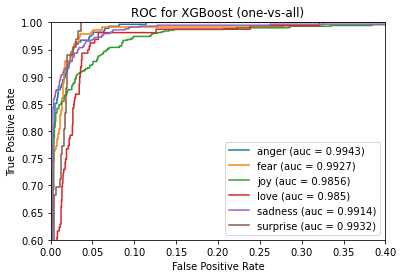

In [41]:
xgb1 = XGBClassifier(
    learning_rate=.3,
    n_estimators=10000,
    max_depth=5,
    min_child_weight=2,
    gamma=0,
    subsample=.9,
    colsample_bytree=.9,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    nthread=-1,
    use_label_encoder=False)

res = fit_model(xgb1, X_trainval, Y_trainval, X_test, Y_test)


### Tune `max_depth` and `min_child_weight`

We first perform a somewhat coarse tuning to get a sense for the range that each value falls into. Grid search cross validation is used to perform the search in parallel over multiple configurations. For the grid search we use the neg_log_loss score as our scoring parameter because of the unbalanced nature of the dataset being used.

In [42]:
n_estimators = xgb1.get_params()['n_estimators']

gs1_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=n_estimators,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

gs1_params = {
    'max_depth':[2, 5, 8, 11],
    'min_child_weight':[1, 2, 3]
}

gs1 = GridSearchCV(estimator=gs1_est, param_grid=gs1_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs1.fit(X_trainval, Y_trainval)

print('Best Params: ', gs1.best_params_)
print('Best Val F1-Score: ',gs1.best_score_)

Y_test_pred = gs1.best_estimator_.predict(X_test)
print('Test micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Params:  {'max_depth': 5, 'min_child_weight': 1}
Best Val F1-Score:  -0.3005519552757318
Test micro F1-Score: 0.901


**Fine Estimation**

Once the first estimation is done we do a finer search around the best parameters found. This provides an even more optimal solution than the one found above.

In [43]:
gs2_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=n_estimators,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

md = gs1.best_params_['max_depth']
mcw = gs1.best_params_['min_child_weight']

gs2_params = {
    'max_depth': [md-1, md, md+1],
    'min_child_weight': [mcw-1, mcw, mcw+1]
}

gs2 = GridSearchCV(estimator=gs2_est, param_grid=gs2_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs2.fit(X_trainval, Y_trainval)

print('Best Params: ', gs2.best_params_)
print('Best Val F1-Score: ', gs2.best_score_)

Y_test_pred = gs2.best_estimator_.predict(X_test)
print('Test micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best Params:  {'max_depth': 5, 'min_child_weight': 0}
Best Val F1-Score:  -0.28561069265486727
Test micro F1-Score: 0.8985


### Tune `gamma`
Gamma is the minimum loss reduction required to make a further partition on the leaf node of a tree. Here we tune gamma using the optimal `max_depth` and `min_child_weight` parameters found in the previous step. Tuning the value of gamma should help overcome overfitting brought on by the high number of features being used.

In [44]:
md = gs2.best_params_['max_depth']
mcw = gs2.best_params_['min_child_weight']
ne = gs2.best_estimator_.get_params()['n_estimators']

gs3_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=ne,
    max_depth=md,
    min_child_weight=mcw,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

gs3_params = {
    'gamma': [0, .5, 1, 1.5]
}

gs3 = GridSearchCV(estimator=gs3_est, param_grid=gs3_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs3.fit(X_trainval, Y_trainval)

print('Best Params: ', gs3.best_params_)
print('Best Val F1-Score: ', gs3.best_score_)

Y_test_pred = gs3.best_estimator_.predict(X_test)
print('Test Micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Params:  {'gamma': 0}
Best Val F1-Score:  -0.28561069265486727
Test Micro F1-Score: 0.8985


**Fine Estimation**

Now that we know the approximate best value of `gamma` we will perform a finer search around that value to pick the optimal value of `gamma`. It's possible this could result in negative values of gamma causing errors, but we'll just ignore those and let the grid search catch them since at least half the gamma inputs will be valid.

In [45]:
gs4_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=ne,
    max_depth=md,
    min_child_weight=mcw,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

g = gs3.best_params_['gamma']

gs4_params = {
    'gamma': [g-.3, g-.2, g-.1, g, g+.1, g+.2, g+.3]
}

gs4 = GridSearchCV(estimator=gs4_est, param_grid=gs4_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs4.fit(X_trainval, Y_trainval)

print('Best Params: ', gs4.best_params_)
print('Best Val F1-Score: ', gs4.best_score_)

Y_test_pred = gs4.best_estimator_.predict(X_test)
print('Test micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 7 candidates, totalling 14 fits


C:\Users\dstum\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 14.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dstum\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dstum\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\dstum\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1261, in fit
    callbacks=callbacks,
  File "C:\Users\dstum\Anaconda3\lib\site-packages\xgboost\training.py", line 196, i

Best Params:  {'gamma': 0.2}
Best Val F1-Score:  -0.27781025770619955
Test micro F1-Score: 0.8975


### Re-evaluate n-estimators

Run cross-validation with early stopping again to update the value of `n_estimators`

[0]	train-mlogloss:1.64617+0.00105	test-mlogloss:1.66111+0.00050
[50]	train-mlogloss:0.60588+0.00376	test-mlogloss:0.67874+0.00082
[100]	train-mlogloss:0.40026+0.00437	test-mlogloss:0.49485+0.00028
[150]	train-mlogloss:0.29882+0.00322	test-mlogloss:0.40831+0.00050
[200]	train-mlogloss:0.23907+0.00272	test-mlogloss:0.36032+0.00109
[250]	train-mlogloss:0.19960+0.00196	test-mlogloss:0.33135+0.00281
[300]	train-mlogloss:0.17164+0.00149	test-mlogloss:0.31201+0.00336
[350]	train-mlogloss:0.15129+0.00162	test-mlogloss:0.29875+0.00455
[400]	train-mlogloss:0.13614+0.00173	test-mlogloss:0.28987+0.00496
[450]	train-mlogloss:0.12512+0.00159	test-mlogloss:0.28349+0.00516
[500]	train-mlogloss:0.11763+0.00182	test-mlogloss:0.27886+0.00512
[550]	train-mlogloss:0.11200+0.00172	test-mlogloss:0.27583+0.00471
[600]	train-mlogloss:0.10700+0.00164	test-mlogloss:0.27308+0.00481
[650]	train-mlogloss:0.10316+0.00154	test-mlogloss:0.27150+0.00447
[700]	train-mlogloss:0.10202+0.00126	test-mlogloss:0.27119+0.0045

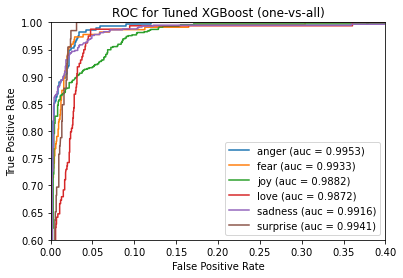

In [46]:
md = gs4.best_estimator_.get_params()['max_depth']
mcw = gs4.best_estimator_.get_params()['min_child_weight']
ne = gs4.best_estimator_.get_params()['n_estimators']
g = gs4.best_estimator_.get_params()['gamma']
subsamp = gs4.best_estimator_.get_params()['subsample']
colsamp = gs4.best_estimator_.get_params()['colsample_bytree']
lam = gs4.best_estimator_.get_params()['reg_lambda']

partial_tuned = XGBClassifier(
    learning_rate=.3,
    n_estimators=100000,
    max_depth=md,
    min_child_weight=mcw,
    gamma=g,
    subsample=subsamp,
    colsample_bytree=colsamp,
    objective='multi:softprob',
    num_class=6,
    reg_lambda=lam,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)


fit_model(partial_tuned, X_trainval, Y_trainval,
          X_test, Y_test, title='Tuned XGBoost')


### Tune `colsample_bytree` and `subsample`

We'll again use a grid search with cross-validation for these hyperparameters.

In [48]:
md = partial_tuned.get_params()['max_depth']
mcw = partial_tuned.get_params()['min_child_weight']
ne = partial_tuned.get_params()['n_estimators']
g = partial_tuned.get_params()['gamma']

gs5_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=ne,
    max_depth=md,
    min_child_weight=mcw,
    gamma=g,
    subsample=1,
    colsample_bytree=1,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

gs5_params = {
    'subsample': [.7, .8, .9, 1],
    'colsample_bytree': [.7, .8, .9, 1]
}

gs5 = GridSearchCV(estimator=gs5_est, param_grid=gs5_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs5.fit(X_trainval, Y_trainval)

print('Best Params: ', gs5.best_params_)
print('Best Val F1-Score: ', gs5.best_score_)

Y_test_pred = gs5.best_estimator_.predict(X_test)
print('Test Micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Params:  {'colsample_bytree': 0.7, 'subsample': 1}
Best Val F1-Score:  -0.2713938150515885
Test Micro F1-Score: 0.897


### Tune `reg_lambda`

`reg_lambda` controls the L2 regularization term on the weights. Tuning this could help with overfitting and will make the model more conservative. The default is set at 1. We don't want any less regularization because it could lead to further overfitting. We will exclusively look at values larger than the default.

In [49]:
md = gs5.best_estimator_.get_params()['max_depth']
mcw = gs5.best_estimator_.get_params()['min_child_weight']
ne = gs5.best_estimator_.get_params()['n_estimators']
g = gs5.best_estimator_.get_params()['gamma']
subsamp = gs5.best_estimator_.get_params()['subsample']
colsamp = gs5.best_estimator_.get_params()['colsample_bytree']

gs6_est = XGBClassifier(
    learning_rate=.3,
    n_estimators=ne,
    max_depth=md,
    min_child_weight=mcw,
    gamma=g,
    subsample=subsamp,
    colsample_bytree=colsamp,
    objective='multi:softprob',
    num_class=6,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)

gs6_params = {
    'reg_lambda':[1, 10, 25, 50] 
}

gs6 = GridSearchCV(estimator=gs6_est, param_grid=gs6_params,
                   scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=1)
gs6.fit(X_trainval, Y_trainval)

print('Best Params: ', gs6.best_params_)
print('Best Val F1-Score: ', gs6.best_score_)

Y_test_pred = gs6.best_estimator_.predict(X_test)
print('Test Micro F1-Score: {:.4}'.format(skm.f1_score(Y_test, Y_test_pred, average='micro')))


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Params:  {'reg_lambda': 1}
Best Val F1-Score:  -0.2713938150515885
Test Micro F1-Score: 0.897


### Update `learning_rate` and `n_estimators`

Now that the parameters of interest have been properly tuned, we reduce the learning rate and re-evaluate the optimal value of `n_estimators` to use in the model. It is expected that the value will be higher then the original value found.

We then evaluate the model and display the final tuned results.

[0]	train-mlogloss:1.71788+0.00065	test-mlogloss:1.72457+0.00092
[50]	train-mlogloss:0.86313+0.00378	test-mlogloss:0.91647+0.00128
[100]	train-mlogloss:0.63296+0.00408	test-mlogloss:0.70149+0.00145
[150]	train-mlogloss:0.50265+0.00397	test-mlogloss:0.58282+0.00126
[200]	train-mlogloss:0.41695+0.00424	test-mlogloss:0.50677+0.00055
[250]	train-mlogloss:0.35624+0.00434	test-mlogloss:0.45345+0.00015
[300]	train-mlogloss:0.31088+0.00367	test-mlogloss:0.41505+0.00023
[350]	train-mlogloss:0.27603+0.00299	test-mlogloss:0.38645+0.00061
[400]	train-mlogloss:0.24853+0.00254	test-mlogloss:0.36433+0.00161
[450]	train-mlogloss:0.22647+0.00243	test-mlogloss:0.34701+0.00226
[500]	train-mlogloss:0.20801+0.00221	test-mlogloss:0.33329+0.00292
[550]	train-mlogloss:0.19227+0.00204	test-mlogloss:0.32242+0.00339
[600]	train-mlogloss:0.17877+0.00182	test-mlogloss:0.31301+0.00399
[650]	train-mlogloss:0.16705+0.00161	test-mlogloss:0.30546+0.00438
[700]	train-mlogloss:0.15736+0.00145	test-mlogloss:0.29927+0.0046

,0
objective,multi:softprob
use_label_encoder,False
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.7
enable_categorical,False
gamma,0.2
gpu_id,-1


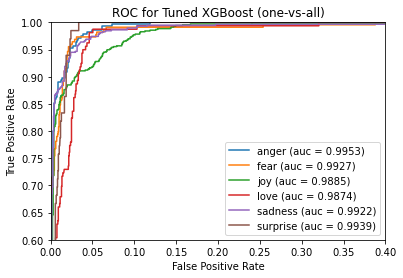

In [57]:
md = gs6.best_estimator_.get_params()['max_depth']
mcw = gs6.best_estimator_.get_params()['min_child_weight']
ne = gs6.best_estimator_.get_params()['n_estimators']
g = gs6.best_estimator_.get_params()['gamma']
subsamp = gs6.best_estimator_.get_params()['subsample']
colsamp = gs6.best_estimator_.get_params()['colsample_bytree']
lam = gs6.best_estimator_.get_params()['reg_lambda']

tuned_est = XGBClassifier(
    learning_rate=.15,
    n_estimators=100000,
    max_depth=md,
    min_child_weight=mcw,
    gamma=g,
    subsample=subsamp,
    colsample_bytree=colsamp,
    objective='multi:softprob',
    num_class=6,
    reg_lambda=lam,
    seed=0,
    tree_method='hist',
    eval_metric='mlogloss',
    use_label_encoder=False)


fit_model(tuned_est, X_trainval, Y_trainval, X_test, Y_test, title='Tuned XGBoost')

print('-------- Final Tuned Parameters --------')
pd.DataFrame(tuned_est.get_params().values(),
             index=tuned_est.get_params().keys())


In [111]:
Y_test_pred = tuned_est.predict(X_test)
Y_test_proba = tuned_est.predict_proba(X_test)

## Evaluate Results

### Confusion Matrix

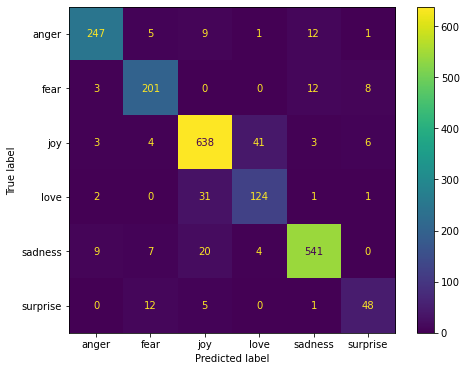

In [112]:
plt.figure(figsize=(8,6))
ax = plt.axes()
skm.ConfusionMatrixDisplay(skm.confusion_matrix(Y_test, Y_test_pred),display_labels=classes).plot(ax=ax)

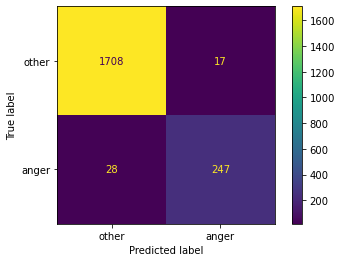

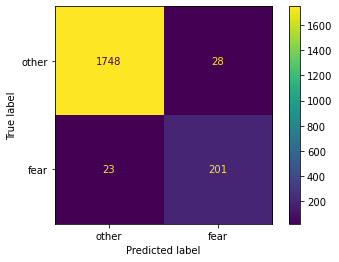

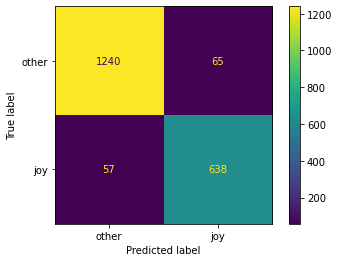

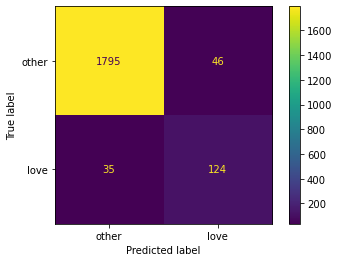

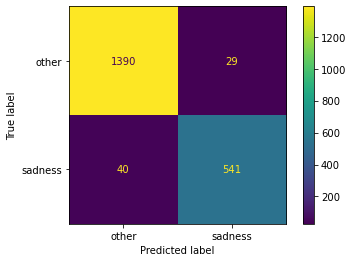

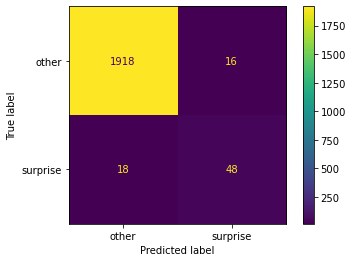

In [113]:
cms = skm.multilabel_confusion_matrix(Y_test, Y_test_pred)

for i, cm in enumerate(cms):
    skm.ConfusionMatrixDisplay(cm,display_labels=['other',classes[i]]).plot()

### Classification Report

In [116]:
print(skm.classification_report(Y_test, Y_test_pred,target_names=classes,digits=3))

              precision    recall  f1-score   support

       anger      0.936     0.898     0.917       275
        fear      0.878     0.897     0.887       224
         joy      0.908     0.918     0.913       695
        love      0.729     0.780     0.754       159
     sadness      0.949     0.931     0.940       581
    surprise      0.750     0.727     0.738        66

    accuracy                          0.899      2000
   macro avg      0.858     0.859     0.858      2000
weighted avg      0.901     0.899     0.900      2000



0.9885

### Incorrect Predictions
Below we display the incorrect predictions made by the classifer. We can observe that while some are just blatantly incorrect, many if not most of the misclassifications seem reasonable and are likely due to the subjective nature of the original ground truth labels provided.

In [121]:
df = pd.DataFrame()
df['text'] = test.text
df['True Label'] = [classes[idx] for idx in Y_test]
df['Predicted Label'] = [classes[idx] for idx in Y_test_pred]
for i in range(len(classes)):
    df['P('+classes[i]+')'] = Y_test_proba[:,i].round(3)
df = df[df['True Label'] != df['Predicted Label']]
df.reset_index(inplace=True, drop=True)
pd.options.display.max_colwidth = 125
display(df)


,text,True Label,Predicted Label,P(anger),P(fear),P(joy),P(love),P(sadness),P(surprise)
0,i felt anger when at the end of a telephone call,anger,joy,0.178,0.104,0.477,0.024,0.213,0.004
1,i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of...,joy,surprise,0.000,0.000,0.079,0.000,0.001,0.919
2,i can t stop the anxiety i feel when i m alone when i ve got no distractions,sadness,joy,0.098,0.108,0.533,0.023,0.234,0.005
3,i have tried to see what it would be like if i liked one of my girl friends but it has never really worked and i can only...,sadness,love,0.006,0.002,0.013,0.572,0.407,0.000
4,i spent wandering around still kinda dazed and not feeling particularly sociable but because id been in hiding for a coup...,joy,surprise,0.000,0.000,0.066,0.000,0.001,0.932
5,i feel a bit stressed even though all the things i have going on are fun,anger,sadness,0.309,0.007,0.032,0.003,0.648,0.001
6,i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love,joy,love,0.002,0.001,0.144,0.850,0.002,0.001
7,i love neglecting this blog but sometimes i feel for my faithful readers,love,joy,0.008,0.008,0.705,0.260,0.011,0.007
8,i lay in bed feeling as though i were awaiting an unwelcome visitor nevertheless i told myself i was strong and thought o...,sadness,joy,0.001,0.001,0.676,0.001,0.321,0.000
9,i feel my heart is tortured by what i have done,anger,fear,0.389,0.593,0.007,0.003,0.008,0.001


### Top-2 Accuracy

As we see from the erroneous predictions, many of them occur because of bad class labels or simply overlap in the sentiment between multiple classes. To help remove this effect from scoring we quantify the top-2 accuracy to see how the model performs using that metric.

In [122]:
print('Top-2 Accuracy: ',skm.top_k_accuracy_score(Y_test, Y_test_proba, k=2))

Top-2 Accuracy:  0.9885
